Import libraries:

In [305]:
import re
import nltk
import random
import pandas as pd
import seaborn as sns
from random import randint
from wordcloud import WordCloud
from textblob import TextBlob

from gensim.summarization import mz_keywords
from gensim.summarization import summarize

from selenium import webdriver
from bs4 import BeautifulSoup
import time
from bs4.element import Tag

from pathlib import Path
import wikipediaapi
import concurrent.futures

import winsound
import numpy as np
import pandas as pd
from tqdm import tqdm
import networkx as nx
from requests import get
from googlesearch import search

from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from bs4.element import Comment
from bs4 import BeautifulSoup
import urllib.request

import time
import collections
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from nltk import tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

from selenium.webdriver.common.keys import Keys
import chromedriver_binary

Import CDFs:

In [304]:
def wiki_scrape(topic_name, verbose=True):
    def wiki_link(link):
        try:
            page = wiki_api.page(link)
            if page.exists():
                d = {'page': link, 'text': page.text, 'link': page.fullurl,
                     'categories': list(page.categories.keys())}
                return d
        except:
            return None

    wiki_api = wikipediaapi.Wikipedia(language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(topic_name)
    if not page_name.exists():
        return
    page_links = list(page_name.links.keys())
    progress = tqdm(desc='Links Scraped', unit='', total=len(page_links)) if verbose else None
    sources = [{'page': topic_name, 'text': page_name.text, 'link': page_name.fullurl,
                'categories': list(page_name.categories.keys())}]
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        future_link = {executor.submit(wiki_link, link): link for link in page_links}
        for future in concurrent.futures.as_completed(future_link):
            data = future.result()
            progress.update(1) if verbose else None
            if data:
                sources.append(data)
    progress.close() if verbose else None
    blacklist = ('Template', 'Help:', 'Category:', 'Portal:', 'Wikipedia:', 'Talk:')
    sources = pd.DataFrame(sources)
    sources = sources[(len(sources['text']) > 20)
                      & ~(sources['page'].str.startswith(blacklist))]
    sources['categories'] = sources.categories.apply(lambda x: [y[9:] for y in x])
    sources['topic'] = topic_name
    return sources

def wiki_page(page_name):
    wiki_api = wikipediaapi.Wikipedia(language='en', extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(page_name)
    if not page_name.exists():
        print('page does not exist')
        return
    page_data = {'page': page_name, 'text': page_name.text, 'link': page_name.fullurl,
                 'categories': [[y[9:] for y in list(page_name.categories.keys())]]}
    page_data_df = pd.DataFrame(page_data)
    return page_data_df

def tags(x):
    return nltk.pos_tag(nltk.word_tokenize(x))[0][1]

def scoring(a,b):
    try:
        a = a.replace(',', '').split()
        b = b.replace(',', '').split()
        score = int(100*len(set(a).intersection(b))/(len(set(a))))
    
    except:
        score = 0    
        
    return score

def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

def text_normalize(txt, nouns=True):
    processed_text = re.sub('[^a-zA-Z]', ' ', txt)
    processed_text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",processed_text)
    processed_text=re.sub("(\\d|\\W)+"," ",processed_text)

    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(processed_text) 
    tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stop_words]
    
    if nouns==True: 
        tokens = [i for i in tokens if ((tags(i) in ['NN', 'NNP', 'NNS', 'NNPS']) and len(i) > 3)]
    
    return tokens

def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return u" ".join(t.strip() for t in visible_texts)


def word_cloud(tokens):
    stop_words = set(stopwords.words("english"))
    bigrams_list = list(nltk.bigrams(tokens))
    dictionary = [' '.join(tup) for tup in bigrams_list]

    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform(dictionary)
    words_freq = [(word, bag_of_words.sum(axis=0)[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    wordcloud = WordCloud(stopwords=stop_words, width=300, height=300, random_state=42, max_words=50, prefer_horizontal=1, background_color='white', max_font_size=256)
    wordcloud.generate_from_frequencies(dict(words_freq))
    
    keys = wordcloud.words_
    
    plt.figure(figsize=(6,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    return keys 
    
def create_graph(text, nodes=25, max_component=False, common=1000):

    ## Normalize text
    tokens = text_normalize(text)
    ## /Normalize text

    ## create graph
    bigrams=list(nltk.ngrams(tokens, 2))
    bigram_counts = collections.Counter(bigrams)

    bigram_df = pd.DataFrame(bigram_counts.most_common(common), columns=['bigram', 'count'])
    d = bigram_df.set_index('bigram').T.to_dict('records')

    F = nx.Graph()
    for k, v in d[0].items():
            F.add_edge(k[0], k[1], weight=(v*10))
    ## /create graph

    pos = nx.spring_layout(F, iterations=500)
    return F, pos

def tree_graph(d):
    valency_list=[d.get(element) for element in d] #list of valency values
    unique_v_list=list(set(valency_list)) #unique valency values

    unique_v_list.reverse()

    N=5 #number of rows
    T=5 #top words

    v_step=[1/N*step for step in range(0,N)] #list of borders for v values
    v_step.reverse()

    d={k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)} #sort d
    levels=[]
    used=[]
    for step in v_step:
        level=[]
        for k in d:
            if d[k]/max(unique_v_list)>step and k not in used:
                level.append(k)
                used.append(k)
        levels.append(level)
    levels=[level for level in levels if level]

    top_levels=[]
    for level in levels:
        if len(level)>T:
            top_levels.append(level[:T])
        else:
            top_levels.append(level)

    levels=top_levels

    gaps=[len(level)-1 for level in levels] #count number of gaps between two words on each level

    lines=[] #get list of strings of every level
    for level in levels:
        level_line=''
        for w in level:
            level_line=level_line+w
        lines.append(level_line)

    longest_symbol_row=max([len(line) for line in lines])+max(gaps)+2 #longest row = longest level + maximum gaps + left and right borders
    ax_step=1/longest_symbol_row #X pos step in the graph

    fig = plt.figure(facecolor='#EBF5FB')
    s=4
    fig.set_size_inches((s+3), s) #set size in inches

    ay_step=1/(len(levels)) #Y pos step in the graph
    i=0
    h_lines_y=[]
    colors=['#D6EAF8','#AED6F1','#85C1E9','#5DADE2','#3498DB']
    for level in levels:
        level_line='' #get length of level
        for w in level:
            level_line=level_line+w
        l_step=(longest_symbol_row-len(level_line))/2-gaps[i]/2  #step from the left to start placing words
        #plt.axhline(y=(1-ay_step*i)+ay_step/2, color='black', ls='dashed')
        h_lines_y.append(1-(i*ay_step))
        color=colors.pop()
        for w in level:
            plt.text(l_step*ax_step+len(w)/2*ax_step, 1-ay_step/2-(i*ay_step), w, fontdict=dict(fontsize=s*130*1/longest_symbol_row), family='monospace', horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor=color, edgecolor='black', boxstyle='round,pad=0.2'))
            l_step=l_step+len(w)+1
        i=i+1

    #plt.axhline(y=0+ay_step/2, color='black', ls='dashed')
    h_lines_y.append(0)
    for y in h_lines_y:
      if y==max(h_lines_y) or y==min(h_lines_y):
        plt.axhline(y=y, color='black')
      else:
        plt.axhline(y=y, color='black', ls='dashed')

    plt.show()
    return

def parse_page(url):
    htmlString = get(url).text
    soup = BeautifulSoup(htmlString, 'html.parser')
    paragraphs = soup.find_all(['a'])
    txt = text_from_html(str(paragraphs))

    return txt

def get_unique_text(document):
    unique_sentences = []
    for sentence in [sent.raw for sent in TextBlob(document).sentences]:
        if sentence not in unique_sentences:
            unique_sentences.append(sentence)
    return ' '.join(unique_sentences)

Create query:

In [314]:
query = 'text summarization'

Parse Wikipedia:

In [315]:
try:
    df = wiki_scrape(query, verbose=True)[:20]
    df = df[['text','link']]
    wikitext = '; '.join(list(df['text'])) 
except:
    wikitext = 'no text found'
    print('Text not found')








Links Scraped:   0%|                                                                             | 0/130 [00:00<?, ?/s]






Links Scraped:   1%|▌                                                                    | 1/130 [00:01<03:00,  1.40s/]






Links Scraped:   5%|███▏                                                                 | 6/130 [00:02<02:06,  1.02s/]






Links Scraped:   7%|████▊                                                                | 9/130 [00:02<01:27,  1.38/s]






Links Scraped:   8%|█████▊                                                              | 11/130 [00:02<01:10,  1.70/s]






Links Scraped:   9%|██████▎                                                             | 12/130 [00:02<00:53,  2.23/s]






Links Scraped:  10%|██████▊                                                             | 13/130 [00:02<00:41,  2.84/s]






Links Scraped:  12%|███████▊                                                            | 15/130 [00:03<00:30, 

Links Scraped:  85%|█████████████████████████████████████████████████████████▏         | 111/130 [00:17<00:02,  6.44/s]






Links Scraped:  86%|█████████████████████████████████████████████████████████▋         | 112/130 [00:17<00:03,  4.80/s]






Links Scraped:  88%|███████████████████████████████████████████████████████████▎       | 115/130 [00:17<00:02,  5.98/s]






Links Scraped:  89%|███████████████████████████████████████████████████████████▊       | 116/130 [00:17<00:03,  4.14/s]






Links Scraped:  92%|█████████████████████████████████████████████████████████████▎     | 119/130 [00:18<00:02,  5.02/s]






Links Scraped:  92%|█████████████████████████████████████████████████████████████▊     | 120/130 [00:18<00:01,  5.10/s]






Links Scraped:  93%|██████████████████████████████████████████████████████████████▎    | 121/130 [00:18<00:01,  5.26/s]






Links Scraped:  95%|███████████████████████████████████████████████████████████████▍   | 123/130 [00:18<00:01,  6.52/s

Parse Google:

In [316]:
chrome_options = webdriver.ChromeOptions()
prefs = {"profile.managed_default_content_settings.images": 2}
chrome_options.add_experimental_option("prefs", prefs)
driver = webdriver.Chrome(chrome_options=chrome_options)

number = 20

google_url = "https://www.google.com/search?q=" + query + "&num=" + str(number)
driver.get(google_url)
time.sleep(randint(1,5))

soup = BeautifulSoup(driver.page_source,'lxml')
result_div = soup.find_all('div', attrs={'class': 'g'})

links = []
titles = []
descriptions = []
for r in result_div:
    try:
        link = r.find('a', href=True)
        title = None
        title = r.find('h3')

        if isinstance(title,Tag):
            title = title.get_text()

        description = None
        description = r.find('span', attrs={'class': 'st'})

        if isinstance(description, Tag):
            description = description.get_text()

        # Check to make sure everything is present before appending
        if link != '' and title != '' and description != '':
            links.append(link['href'])
            titles.append(title)
            descriptions.append(description)
    # Next loop if one element is not present
    except Exception as e:
        print(e)
        continue

url_list = links[:(number-2)]

txt = []
for j in tqdm(url_list): 
    delta = random.randint(1,8)
    time.sleep(delta) 
    txt.append(parse_page(j))
       
summ = '; '.join(txt)
googletext = re.sub('[^A-Za-z0-9.]+', ' ', summ)

C:\Users\skamenshchikov\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: use options instead of chrome_options
  after removing the cwd from sys.path.







  0%|                                                                                           | 0/18 [00:00<?, ?it/s]






  6%|████▌                                                                              | 1/18 [00:06<01:56,  6.88s/it]






 11%|█████████▏                                                                         | 2/18 [00:15<01:59,  7.45s/it]






 17%|█████████████▊                                                                     | 3/18 [00:18<01:32,  6.15s/it]






 22%|██████████████████▍                                                                | 4/18 [00:24<01:23,  5.95s/it]






 28%|███████████████████████                                                            | 5/18 [00:33<01:29,  6.91s/it]






 33%|███████████████████████████▋                             

Get wordcloud:

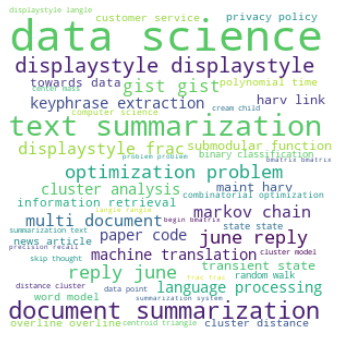

In [320]:
final_text = (wikitext + ' ' + googletext)
final_text = get_unique_text(final_text)
tokens = text_normalize(final_text, nouns=True)
keys = word_cloud(tokens)

Get keywords:

In [321]:
keys_mz = mz_keywords(final_text, scores=True)

print('<Countvec Keywords:>')
print(', '.join(list(keys.keys())[:30]))

print('\n<Entropy Keywords:>')
print(', '.join(list([i[0] for i in keys_mz if len(i[0]) > 3][:30])[:30]))

C:\Users\skamenshchikov\Anaconda3\lib\site-packages\gensim\summarization\mz_entropy.py:65: RuntimeWarning: divide by zero encountered in log2
  log_p = np.log2(p)
C:\Users\skamenshchikov\Anaconda3\lib\site-packages\gensim\summarization\mz_entropy.py:66: RuntimeWarning: invalid value encountered in multiply
  h = np.nan_to_num(p * log_p).sum(axis=0)


<Countvec Keywords:>
data science, text summarization, document summarization, displaystyle displaystyle, june reply, reply june, optimization problem, gist gist, multi document, markov chain, displaystyle frac, cluster analysis, machine translation, language processing, paper code, keyphrase extraction, submodular function, maint harv, harv link, transient state, information retrieval, towards data, word model, customer service, overline overline, cluster distance, polynomial time, privacy policy, news article, binary classification

<Entropy Keywords:>
displaystyle, summarization, clustering, data, centroid, text, cluster, reply, learning, optimization, clusters, science, state, document, chatbots, june, words, submodular, problems, arxiv, abstract, problem, edit, triangle, evaluation, gist, human, chatbot, frac, density


Get abstract:

In [324]:
sent_num = 10
ratio = sent_num/len(nltk.sent_tokenize(final_text))
txt = summarize(final_text, ratio=ratio)
txt = txt.replace('\n', '')
# print('Compression:', int(100*ratio), '%')
print(txt)

Automatic summarization is the process of shortening a set of data computationally, to create a subset (a summary) that represents the most important or relevant information within the original content.Examples of extracted content include key-phrases that can be used to "tag" or index a text document, or key sentences (including headings) that collectively comprise an abstract, and representative images or video segments, as stated above.Some techniques and algorithms which naturally model summarization problems are TextRank and PageRank, Submodular set function, Determinantal point process, maximal marginal relevance (MMR) etc.Typically features involve various term frequencies (how many times a phrase appears in the current text or in a larger corpus), the length of the example, relative position of the first occurrence, various boolean syntactic features (e.g., contains all caps), etc.For example, if we rank unigrams and find that "advanced", "natural", "language", and "processing"

Get tree graph:

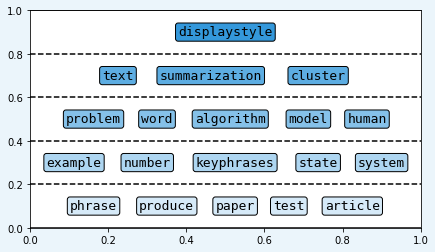

In [325]:
F,pos = create_graph(final_text)
d = dict(F.degree)
tree_graph(d)